# Goals and objectives of the project
Perform exploratory data analysis using the example of a dataset
with a target variable containing the values ​​of students' scores in mathematics

# Libraries import

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sb
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from itertools import combinations

# Init

In [76]:
sb.set_style("darkgrid")

# Functions

In [77]:
def fillna_median(df, col):
    """
    Function fills NaN values in column of df with MEDIAN value.
    :param col: Column to replace NaN with median
    :param df: Dataframe with specified column
    """
    df.fillna({col : df[col].median()}, inplace=True)

def fillna_mode(df, col):
    """
    Function fills NaN values in column of df with MODE value.
    :param col: Column to replace NaN with mode
    :param df: Dataframe with specified column
    """
    df.fillna({col : df[col].mode().iloc[0]}, inplace=True)

def fill_IQR_outliers_median(df, col):
    """
    Function defines and fills outliers in column of df with MEDIAN value based on IQR criterion.
    :param col: Column to replace outliers with median
    :param df: Dataframe with specified column
    """
    q1, q3 = df[col].quantile([0.25, 0.75])
    IQR = q3 - q1
    df.loc[~df[col].between(q1-1.5*IQR, q3+1.5*IQR), col] = df[col].median()

def show_boxplot(df, qual_col, y_col):
    """
    Show boxplots for every qualitative value in specified column
    :param df: DataFrame
    :param qual_col: Column with qualitative values
    :param y_col: y variable for boxplot
    """
    n_unique = df[qual_col].nunique()
    fig, ax = plt.subplots(figsize = (1.5*n_unique, 4))
    sb.boxplot(x=qual_col, y=y_col, data=df, ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + qual_col)
    plt.show()

def check_ttest_diff(df, qual_col, dependent_var, p_value):
    """
    Compute Student's T-test statistics between all categories in col and print results
    :param df: DataFrame
    :param qual_col: Qualitative column with categories in interest in specified df
    :param dependent_var: Name of the column with dependent variable
    :param p_value: Desired p-value threshold
    :return: Test result for specified column:
                True - if T-test was passed
                       (there IS statistically significant differences within column)
                False - if T-test was failed
                        (there IS NO statistically significant differences within column)
    """
    categories = df[qual_col].unique()
    cat_combinations = list(combinations(categories, 2))
    n_cat = len(cat_combinations)
    for category_pair in cat_combinations:
        p = ttest_ind(df.loc[df[qual_col] == category_pair[0], dependent_var],
                      df.loc[df[qual_col] == category_pair[1], dependent_var]).pvalue
        # T-test with Bonferroni correction
        if p <= p_value/n_cat:
            print(f'Statistically significant differences via T-test were found for column \'{qual_col}\', p={p}')
            return True
        else:
            print(f'NO statistically significant differences via T-test were found for column \'{qual_col}\', p={p}')

    return False

def check_anova_diff(df, qual_col, dependent_var, p_value):
    """
    Compute Student's T-test statistics between all categories in col and print results
    :param df: DataFrame
    :param qual_col: Qualitative column with categories in interest in specified df
    :param dependent_var: Name of the column with dependent variable
    :param p_value: Desired p-value threshold
    :return: Test result for specified column:
                True - if T-test was passed
                       (there IS statistically significant differences within column)
                False - if T-test was failed
                        (there IS NO statistically significant differences within column)
    """
    categories = list(df[qual_col].unique())
    f, p = f_oneway(*[df.loc[df[qual_col] == cat, dependent_var] for cat in categories])
    if p<=p_value:
        result = True
        print(f'Statistically significant differences via ANOVA test were found for column \'{qual_col}\', F={f}, p={p}')
    else:
        result = False
        print(f'NO statistically significant differences via ANOVA test were found for column \'{qual_col}\', F={f}, p={p}')

    return result

# Data loading

In [78]:
stud_df_orig = pd.read_csv('stud_math.xls')
stud_df_orig.sample(10)
stud_df_orig.info()
stud_df_orig.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,371.000000,367.000000,388.000000,373.000000,388.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.614555,1.438692,2.038660,0.337802,-6.115979,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,2.228732,0.694181,0.842078,0.743135,2.526235,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


# Exploratory data analysis

In [79]:
# In general our data rather "good" as we can judge on its text table analysis - no strange/corrupted values,
# so we can proceed directly with EDA

# Analyze missed values in data
missing_stat = {}
for col in stud_df_orig.columns:
    missing_stat[col] = round(100*stud_df_orig[col].isna().sum() / len(stud_df_orig.index), 2)
missing_stat = dict(sorted(missing_stat.items(), key=lambda item: item[1], reverse=True))
print('Missing value percents:')
display(missing_stat)

# Conclusion
# Max amount of missed values - 11.39%, so in general we have enough data for EDA

Missing value percents:


{'Pstatus': 11.39,
 'paid': 10.13,
 'famsup': 9.87,
 'Fjob': 9.11,
 'internet': 8.61,
 'guardian': 7.85,
 'romantic': 7.85,
 'traveltime': 7.09,
 'famsize': 6.84,
 'famrel': 6.84,
 'Fedu': 6.08,
 'failures': 5.57,
 'higher': 5.06,
 'Mjob': 4.81,
 'address': 4.3,
 'reason': 4.3,
 'nursery': 4.05,
 'health': 3.8,
 'activities': 3.54,
 'absences': 3.04,
 'freetime': 2.78,
 'schoolsup': 2.28,
 'goout': 2.03,
 'studytime': 1.77,
 'studytime, granular': 1.77,
 'score': 1.52,
 'Medu': 0.76,
 'school': 0.0,
 'sex': 0.0,
 'age': 0.0}

In [80]:
# Fortunately our target variable "score" has comparably small amount of missing values (1,52%),
# because we need to drop this records for further analysis
stud_df = stud_df_orig.dropna(subset=['score'])
stud_df.info()
# now we have 389 rows in our stud_df DataFrame

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               389 non-null    object 
 1   sex                  389 non-null    object 
 2   age                  389 non-null    int64  
 3   address              374 non-null    object 
 4   famsize              362 non-null    object 
 5   Pstatus              344 non-null    object 
 6   Medu                 386 non-null    float64
 7   Fedu                 365 non-null    float64
 8   Mjob                 370 non-null    object 
 9   Fjob                 353 non-null    object 
 10  reason               372 non-null    object 
 11  guardian             358 non-null    object 
 12  traveltime           361 non-null    float64
 13  studytime            382 non-null    float64
 14  failures             367 non-null    float64
 15  schoolsup            380 non-null    obj

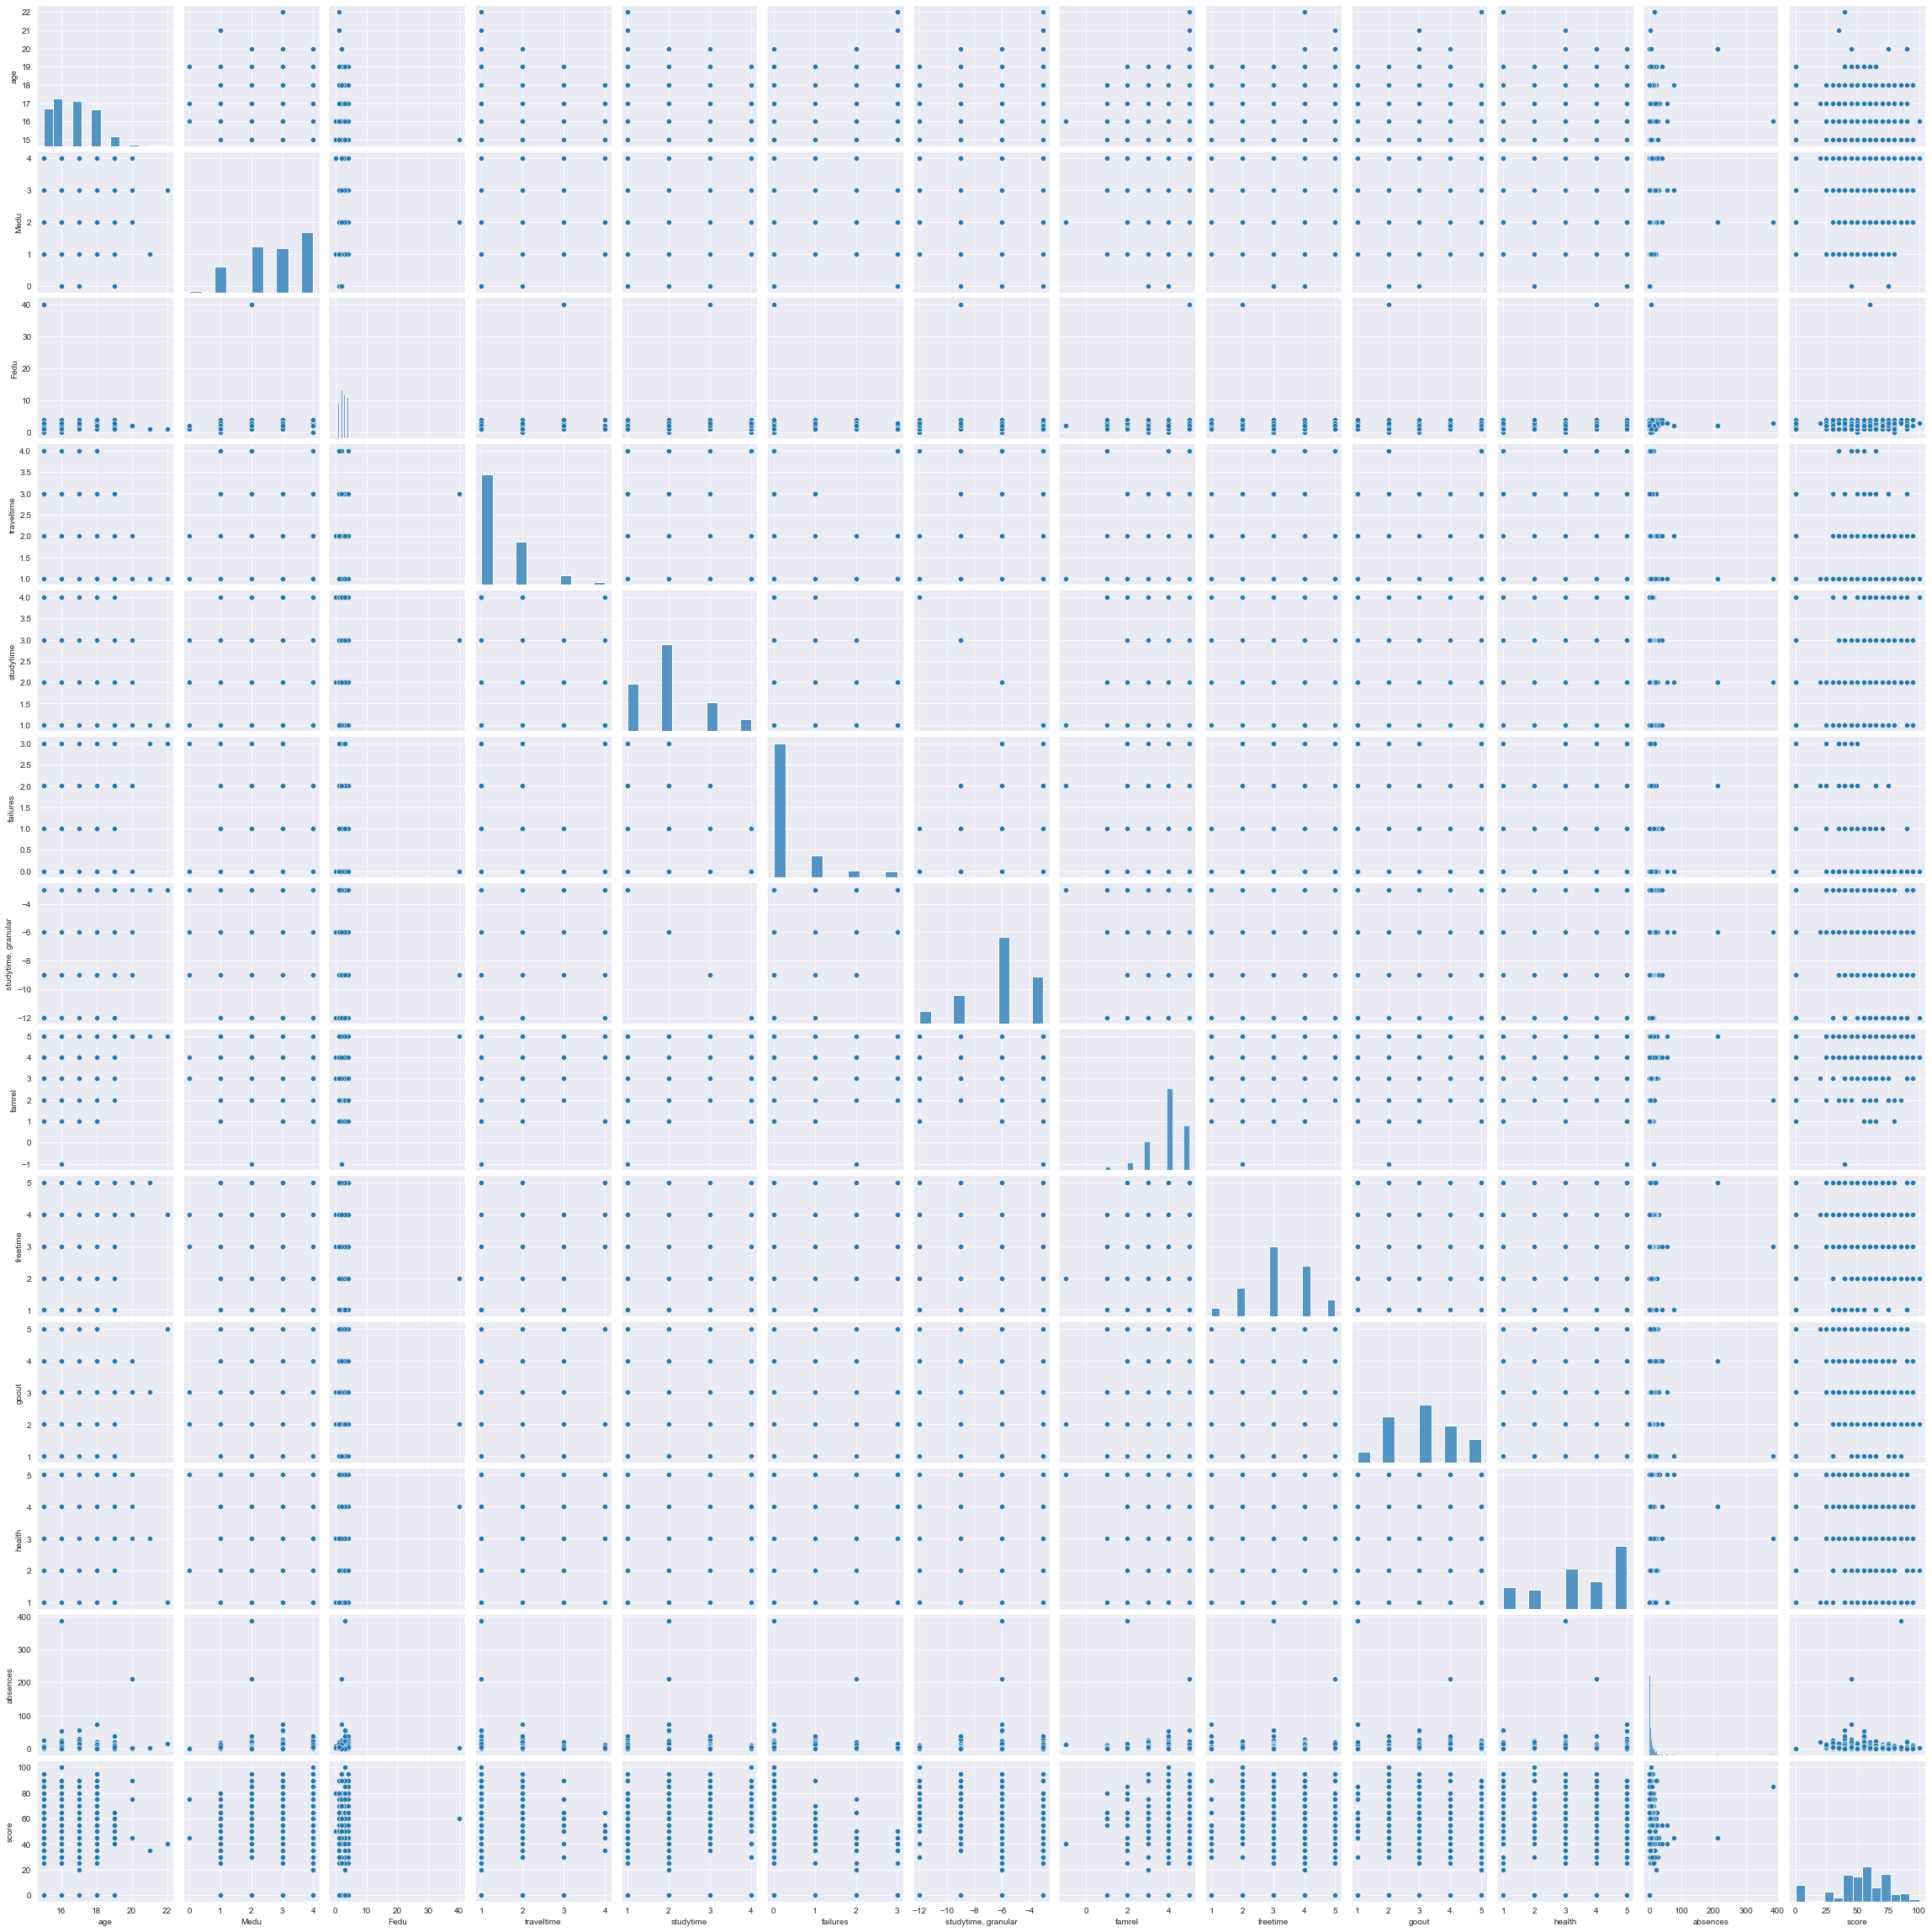

In [81]:
# Overview of the source data. Not very informative due to number of features, but still useful
sb.pairplot(stud_df)

## Primary data processing

In [82]:
# Let's see on every column and preprocess them if necessary (NaN, outliers)

In [83]:
# Column 'school'
stud_df['school'].value_counts(dropna=False)
# everything looks OK. We have two schools (GP and MS) and expectedly no NaN

GP    344
MS     45
Name: school, dtype: int64

In [84]:
# Column 'sex'
stud_df['sex'].value_counts(dropna=False)
# again everything is OK.

F    204
M    185
Name: sex, dtype: int64

16    103
17     98
15     82
18     80
19     21
20      3
21      1
22      1
Name: age, dtype: int64


<AxesSubplot:>

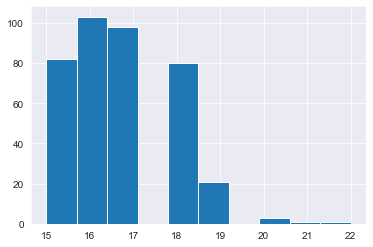

In [85]:
# Column 'age'
print(stud_df['age'].value_counts(dropna=False))
stud_df['age'].hist()
# everything is OK. No NaN values, no outliers (from description should be between 15 and 22 and it is).
# Wish all the data would be like this..;)

In [86]:
# We know that in other columns with qualitative variables there are some NaN values
# Let's replace them with mode value in universal manner
# (including columns without NaN is OK, they just remain unchanged)
qualitative_cols = stud_df.select_dtypes(include='object').columns

for col in qualitative_cols:
    print('Processing column ', col.upper())
    print(stud_df[col].value_counts(dropna=False))

    fillna_mode(stud_df, col)

    print(stud_df[col].value_counts(dropna=False))

# Looking on the processing results we see no strange/corrupted nominal values
# and no NaN values after substitution with mode(), so far so good

Processing column  SCHOOL
GP    344
MS     45
Name: school, dtype: int64
GP    344
MS     45
Name: school, dtype: int64
Processing column  SEX
F    204
M    185
Name: sex, dtype: int64
F    204
M    185
Name: sex, dtype: int64
Processing column  ADDRESS
U      291
R       83
NaN     15
Name: address, dtype: int64
U    306
R     83
Name: address, dtype: int64
Processing column  FAMSIZE
GT3    255
LE3    107
NaN     27
Name: famsize, dtype: int64
GT3    282
LE3    107
Name: famsize, dtype: int64
Processing column  PSTATUS
T      308
NaN     45
A       36
Name: Pstatus, dtype: int64
T    353
A     36
Name: Pstatus, dtype: int64
Processing column  MJOB
other       127
services     98
at_home      58
teacher      55
health       32
NaN          19
Name: Mjob, dtype: int64
other       146
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64
Processing column  FJOB
other       194
services     99
NaN          36
teacher      29
at_home      16
health       

C:\ProgramData\Anaconda3\envs\module_2\lib\site-packages\pandas\core\series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Processing column  AGE
Number of NaN in  age  =  0
Number of NaN in  age  after fillna =  0
Processing column  MEDU
Number of NaN in  Medu  =  3
Number of NaN in  Medu  after fillna =  0
Processing column  FEDU
Number of NaN in  Fedu  =  24
Number of NaN in  Fedu  after fillna =  0
Processing column  TRAVELTIME
Number of NaN in  traveltime  =  28
Number of NaN in  traveltime  after fillna =  0
Processing column  STUDYTIME
Number of NaN in  studytime  =  7
Number of NaN in  studytime  after fillna =  0
Processing column  FAILURES
Number of NaN in  failures  =  22
Number of NaN in  failures  after fillna =  0
Processing column  STUDYTIME, GRANULAR
Number of NaN in  studytime, granular  =  7
Number of NaN in  studytime, granular  after fillna =  0
Processing column  FAMREL
Number of NaN in  famrel  =  27
Number of NaN in  famrel  after fillna =  0
Processing column  FREETIME
Number of NaN in  freetime  =  9
Number of NaN in  freetime  after fillna =  0
Processing column  GOOUT
Number of N

C:\ProgramData\Anaconda3\envs\module_2\lib\site-packages\pandas\core\series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\ProgramData\Anaconda3\envs\module_2\lib\site-packages\pandas\core\series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\ProgramData\Anaconda3\envs\module_2\lib\site-packages\pandas\core\series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast

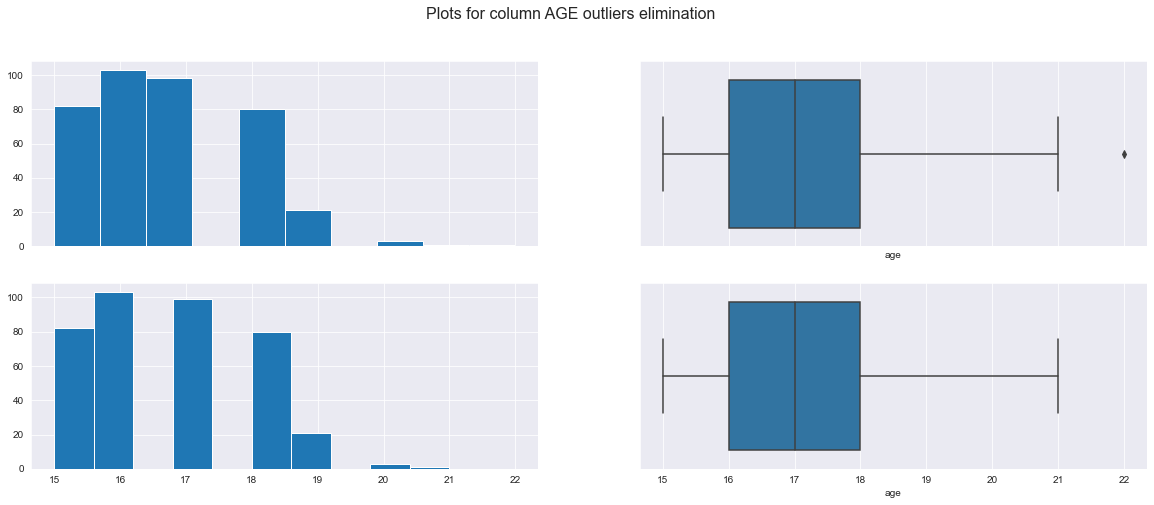

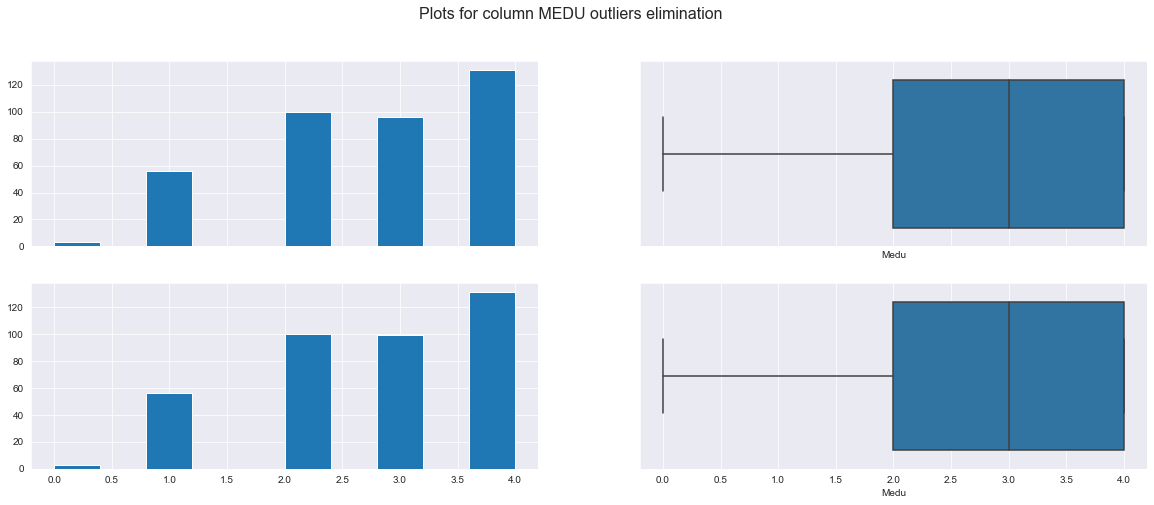

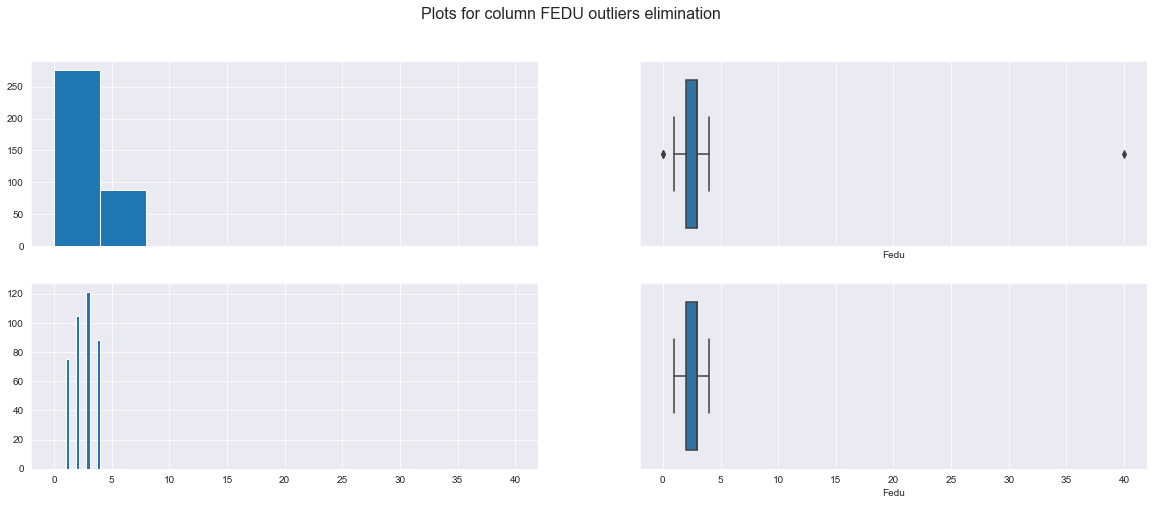

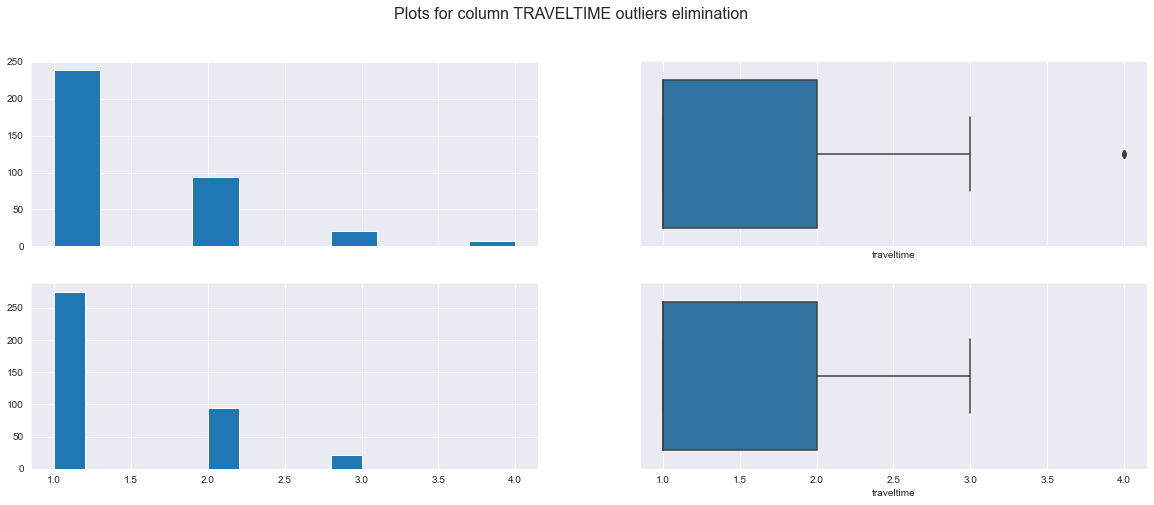

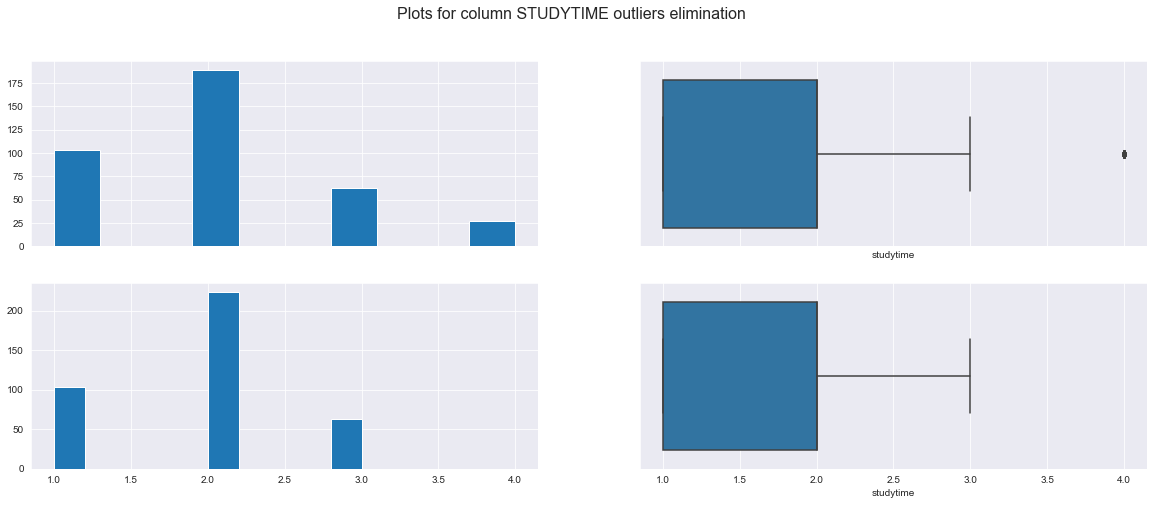

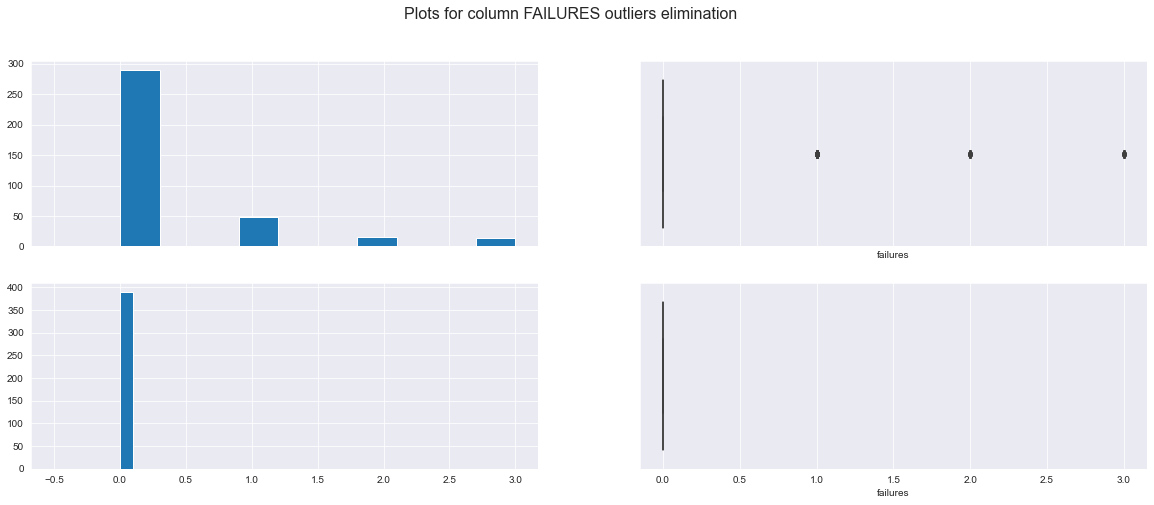

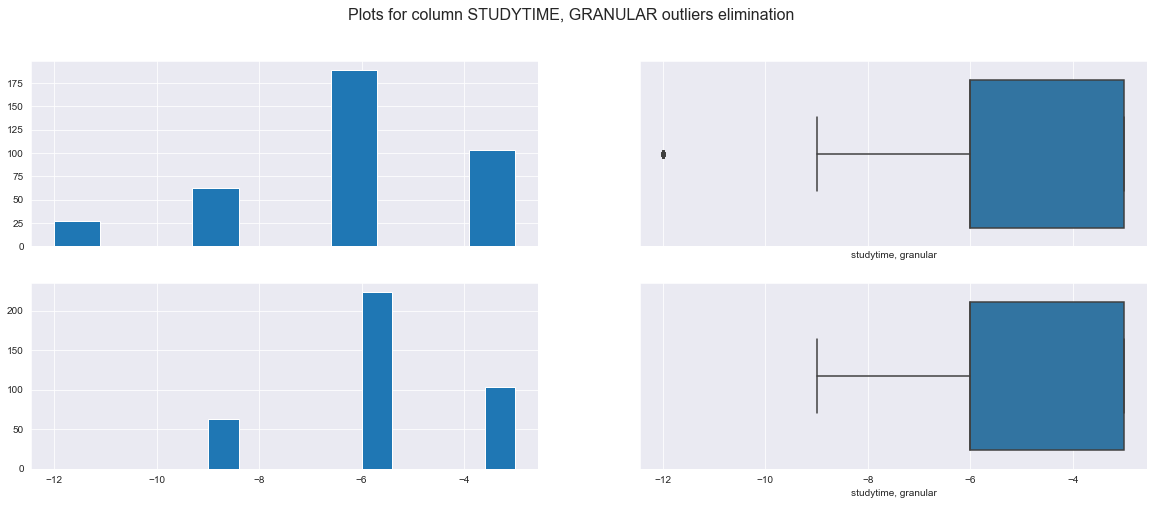

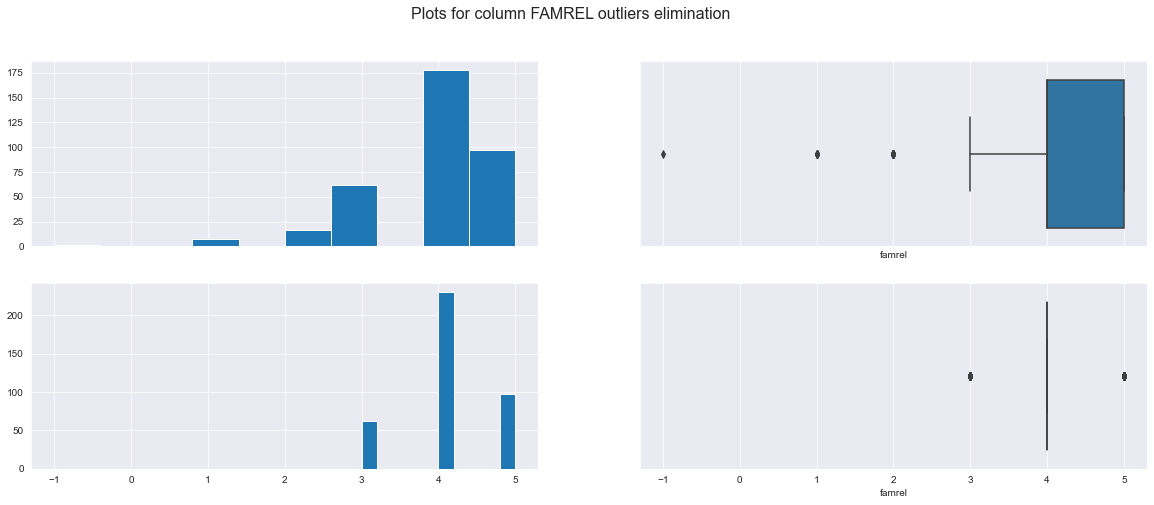

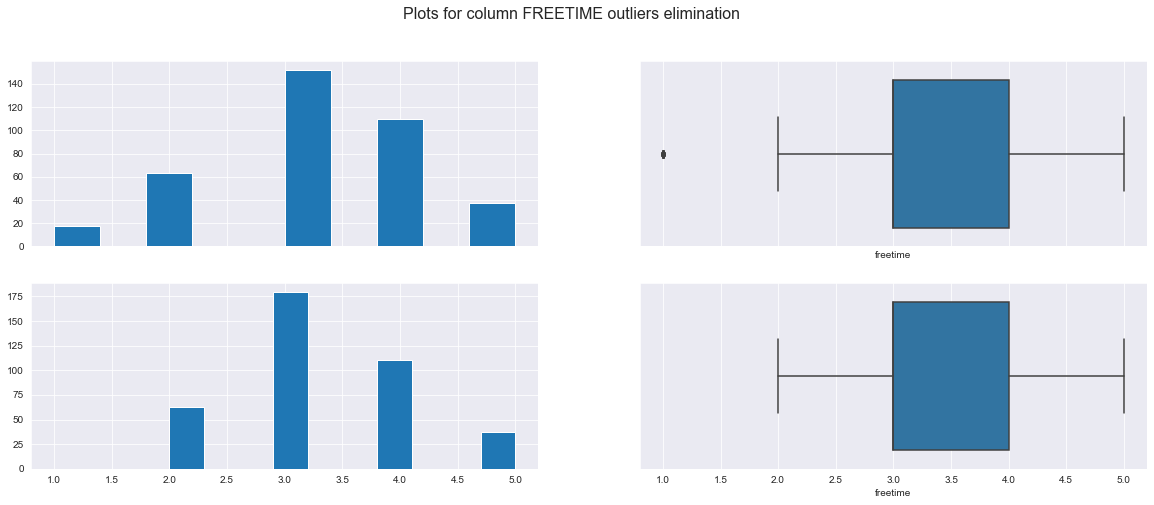

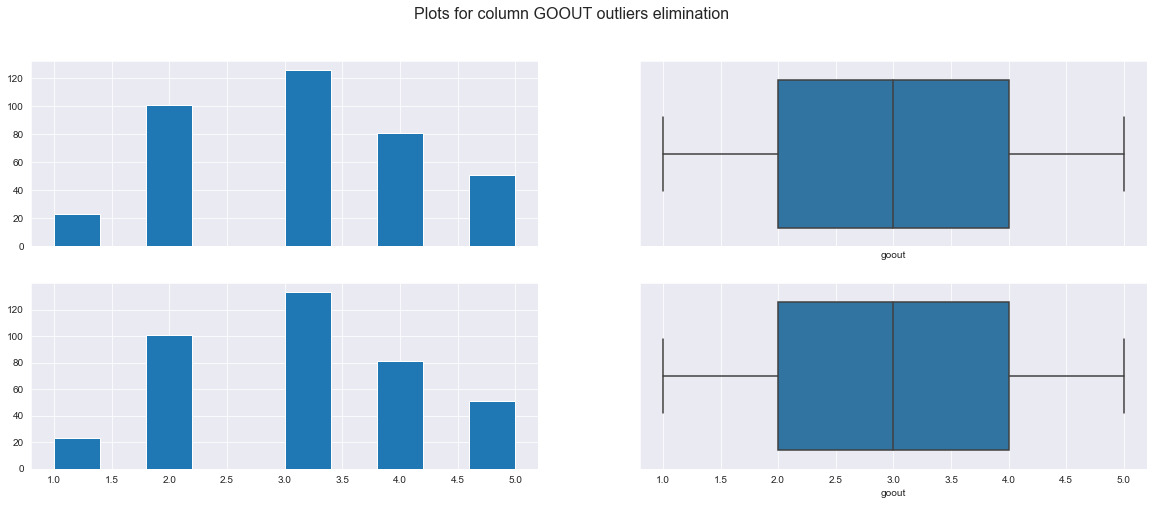

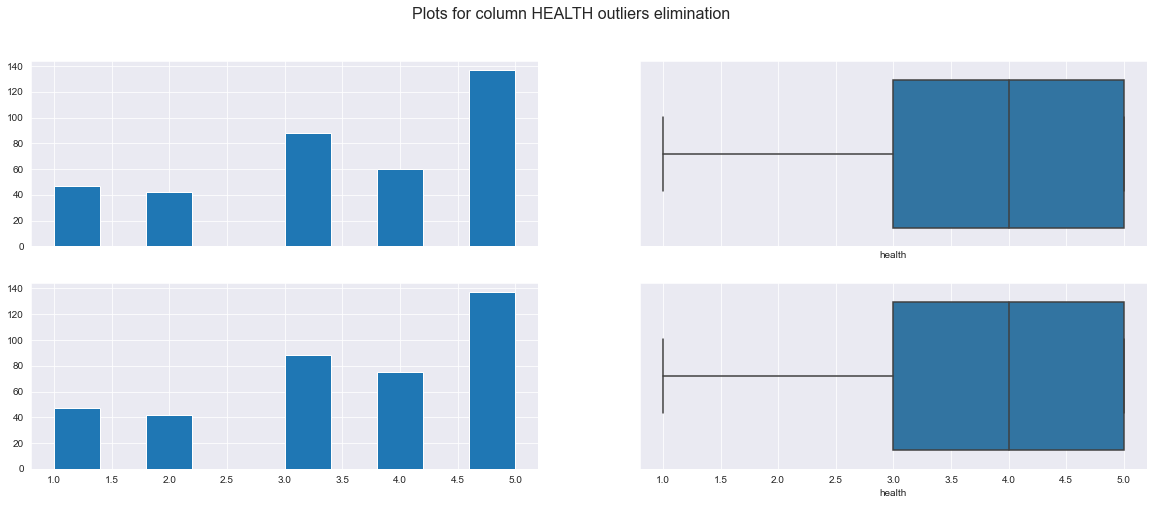

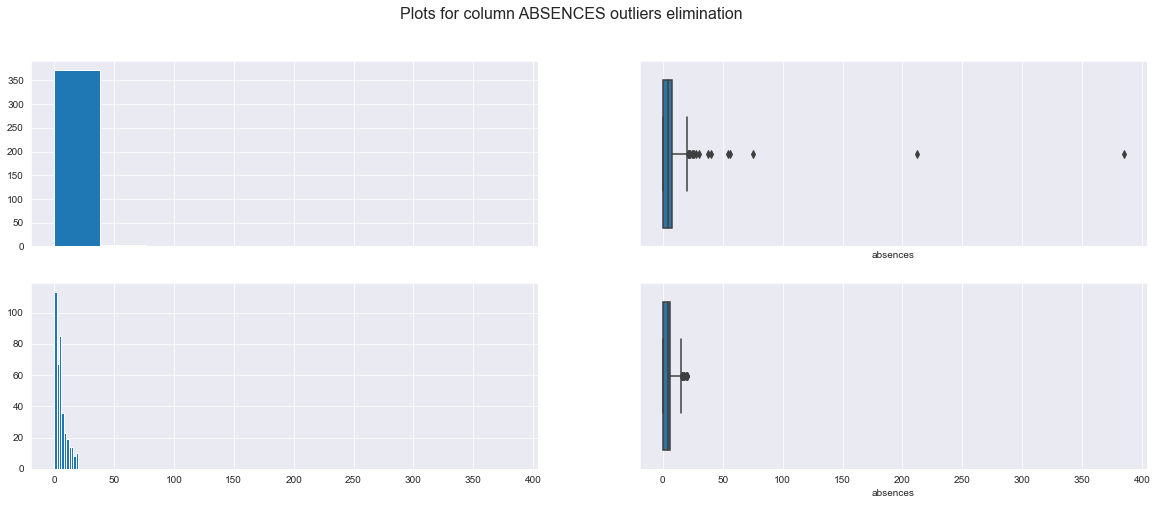

In [87]:
# Now process quantitative variables (excluding dependent variable 'score')
quantitative_cols = list(stud_df.select_dtypes(include=['int64', 'float64']).columns)
quantitative_cols.remove('score')

# df for straightforward outliers processing attempt
stud_df_outliers_test = stud_df.copy()

for col in quantitative_cols:
    print('Processing column ', col.upper())
    print('Number of NaN in ', col, ' = ', stud_df[col].isna().sum())

    fillna_median(stud_df, col)

    print('Number of NaN in ', col, ' after fillna = ', stud_df[col].isna().sum())

    # try process outliers in same loop
    # plot graphs before and after !very straightforward! dealing with outliers
    fig, axs = plt.subplots(2,2, figsize=[20,7.5], sharex='col')
    stud_df_outliers_test[col].hist(ax=axs[0,0])
    sb.boxplot(x=stud_df_outliers_test[col], ax=axs[0,1])

    fill_IQR_outliers_median(stud_df_outliers_test, col)

    stud_df_outliers_test[col].hist(ax=axs[1,0])
    sb.boxplot(x=stud_df_outliers_test[col], ax=axs[1,1])
    fig.suptitle(f'Plots for column {col.upper()} outliers elimination', fontsize=16)


# Conclusion
# Dealing with outliers of all columns in the same way via IQR threshold - not a good idea.
# Need common sense! So let's process outliers separately for each column

In [88]:
# Column 'age'
print(stud_df['age'].value_counts(dropna=False))
# No outliers according to description (from 15 to 22)

16    103
17     98
15     82
18     80
19     21
20      3
21      1
22      1
Name: age, dtype: int64


In [89]:
# Column 'Medu'
print(stud_df['Medu'].value_counts(dropna=False))
# No outliers according to description (from 0 to 4)

4.0    131
2.0    100
3.0     99
1.0     56
0.0      3
Name: Medu, dtype: int64


In [90]:
# Column 'Fedu'
print(stud_df['Fedu'].value_counts(dropna=False))
# There is an obvious outlier: 40.
# Let's just guess that it should be 4.0 like others especially since 4.0 is nota mode but rather often value
stud_df.loc[stud_df['Fedu'] == 40,'Fedu'] = 4
print(stud_df['Fedu'].value_counts(dropna=False))

3.0     118
2.0     105
4.0      88
1.0      75
0.0       2
40.0      1
Name: Fedu, dtype: int64
3.0    118
2.0    105
4.0     89
1.0     75
0.0      2
Name: Fedu, dtype: int64


C:\ProgramData\Anaconda3\envs\module_2\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [91]:
# Column 'traveltime'
print(stud_df['traveltime'].value_counts(dropna=False))
# No outliers according to description (from 1 to 4)

1.0    267
2.0     94
3.0     21
4.0      7
Name: traveltime, dtype: int64


In [92]:
# Column 'studytime'
print(stud_df['studytime'].value_counts(dropna=False))
# No outliers according to description (from 1 to 4)

2.0    196
1.0    103
3.0     63
4.0     27
Name: studytime, dtype: int64


In [93]:
# Column 'studytime, granular'
print(stud_df['studytime, granular'].value_counts(dropna=False))
# already can see the correlation in frequency with 'studytime'

-6.0     196
-3.0     103
-9.0      63
-12.0     27
Name: studytime, granular, dtype: int64


In [94]:
# Column 'failures'
print(stud_df['failures'].value_counts(dropna=False))
# No outliers according to description (from 0 to 3)

0.0    312
1.0     48
2.0     15
3.0     14
Name: failures, dtype: int64


In [95]:
# Column 'famrel'
print(stud_df['famrel'].value_counts(dropna=False))
# There is an obvious outlier: -1. Replace it with median
stud_df.loc[stud_df['famrel'] == -1,'famrel'] = stud_df['famrel'].median()
print(stud_df['famrel'].value_counts(dropna=False))

 4.0    205
 5.0     97
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64
4.0    206
5.0     97
3.0     62
2.0     17
1.0      7
Name: famrel, dtype: int64


C:\ProgramData\Anaconda3\envs\module_2\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [96]:
# Column 'freetime'
print(stud_df['freetime'].value_counts(dropna=False))
# No outliers according to description (from 1 to 5)

3.0    161
4.0    110
2.0     63
5.0     37
1.0     18
Name: freetime, dtype: int64


In [97]:
# Column 'goout'
print(stud_df['goout'].value_counts(dropna=False))
# No outliers according to description (from 1 to 5)

3.0    133
2.0    101
4.0     81
5.0     51
1.0     23
Name: goout, dtype: int64


In [98]:
# Column 'health'
print(stud_df['health'].value_counts(dropna=False))
# No outliers according to description (from 1 to 5)

5.0    137
3.0     88
4.0     75
1.0     47
2.0     42
Name: health, dtype: int64


0.0      110
4.0       63
2.0       60
6.0       30
8.0       20
10.0      17
14.0      12
12.0      12
16.0       7
3.0        7
7.0        6
18.0       5
5.0        5
20.0       4
9.0        3
22.0       3
1.0        3
13.0       2
15.0       2
11.0       2
40.0       1
38.0       1
56.0       1
23.0       1
24.0       1
25.0       1
385.0      1
17.0       1
75.0       1
21.0       1
212.0      1
28.0       1
19.0       1
26.0       1
30.0       1
54.0       1
Name: absences, dtype: int64


C:\ProgramData\Anaconda3\envs\module_2\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


<AxesSubplot:xlabel='absences', ylabel='Count'>

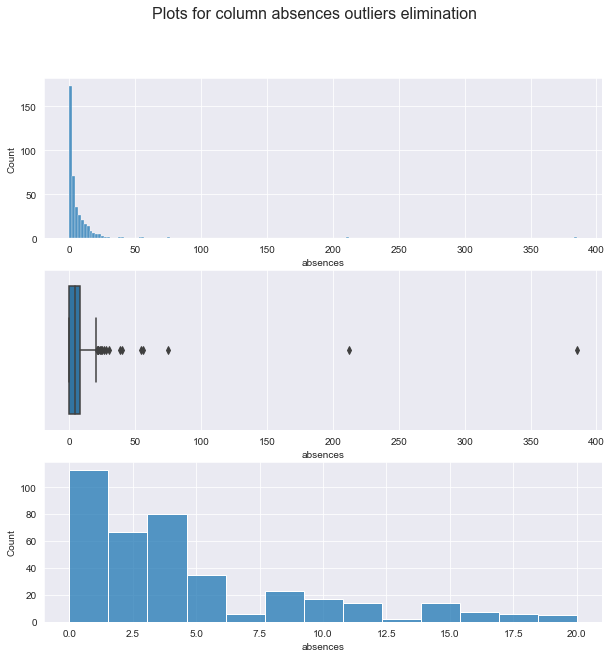

In [99]:
# Column 'absences'
print(stud_df['absences'].value_counts(dropna=False))
fig, axs = plt.subplots(3,1, figsize=[10,10])
sb.histplot(x=stud_df['absences'], ax=axs[0])
sb.boxplot(x=stud_df['absences'], ax=axs[1])
fig.suptitle(f'Plots for column absences outliers elimination', fontsize=16)

fill_IQR_outliers_median(stud_df, 'absences')

sb.histplot(x=stud_df['absences'], ax=axs[2])

Now all columns are ready for further analysis

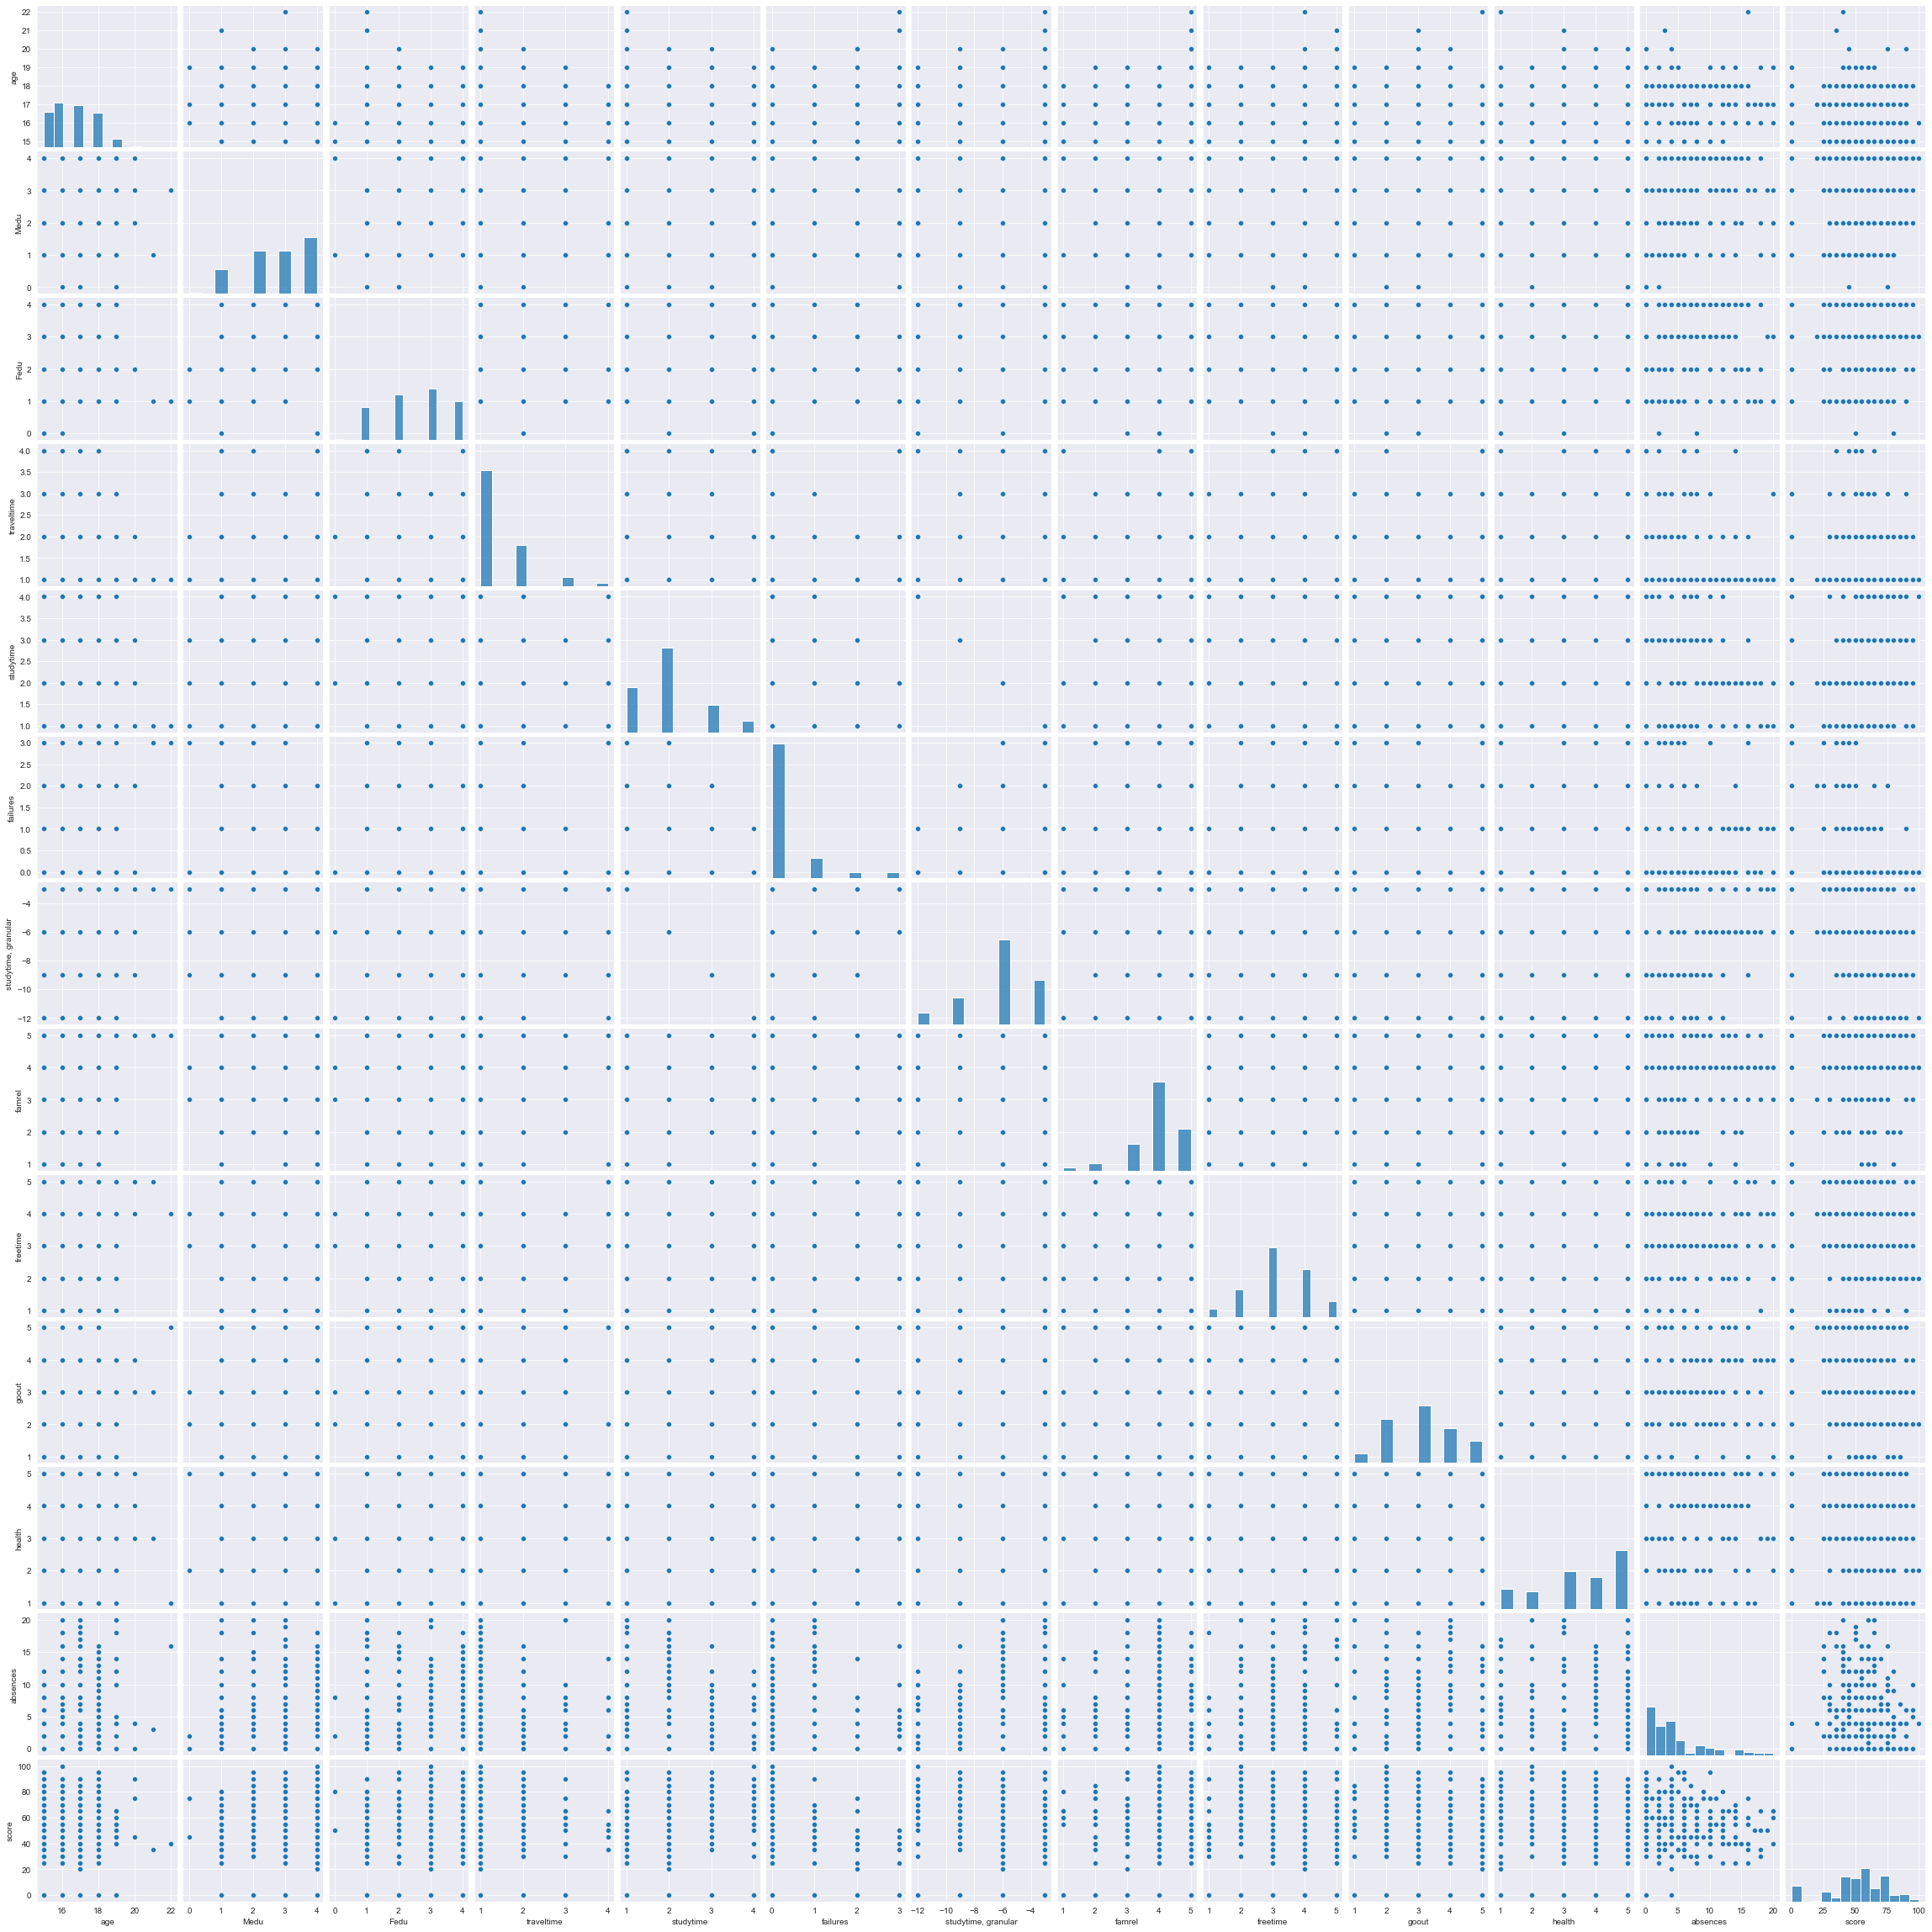

In [100]:
# One more global overview of the already preprocessed data. Looks better.
sb.pairplot(stud_df)

# Correlation analysis

<AxesSubplot:>

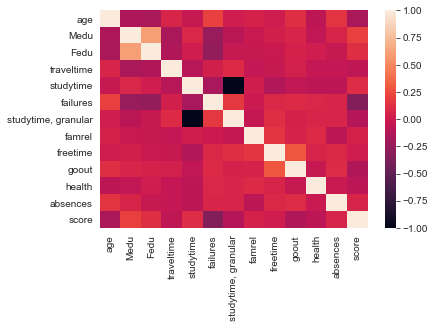

In [101]:
# calculate the correlation matrix
corr = stud_df.corr()
# plot the heatmap
sb.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

# Conclusions
# Variable 'studytime, granular' is strongly negatively correlated with 'studytime' and can be excluded.
# Father and mother education level is rather correlated with each other

In [102]:
# So exclude 'studytime, granular' column from dataset
stud_df = stud_df.drop(columns='studytime, granular')
stud_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    object 
 1   sex         389 non-null    object 
 2   age         389 non-null    int64  
 3   address     389 non-null    object 
 4   famsize     389 non-null    object 
 5   Pstatus     389 non-null    object 
 6   Medu        389 non-null    float64
 7   Fedu        389 non-null    float64
 8   Mjob        389 non-null    object 
 9   Fjob        389 non-null    object 
 10  reason      389 non-null    object 
 11  guardian    389 non-null    object 
 12  traveltime  389 non-null    float64
 13  studytime   389 non-null    float64
 14  failures    389 non-null    float64
 15  schoolsup   389 non-null    object 
 16  famsup      389 non-null    object 
 17  paid        389 non-null    object 
 18  activities  389 non-null    object 
 19  nursery     389 non-null    o

# Qualitative variables analysis

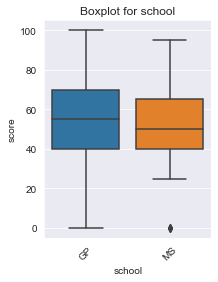

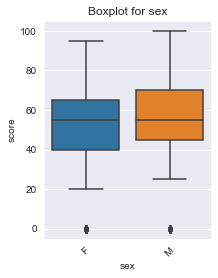

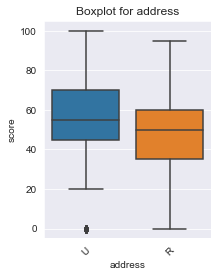

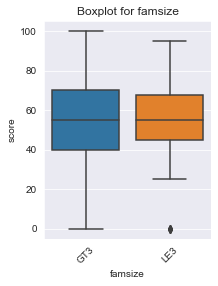

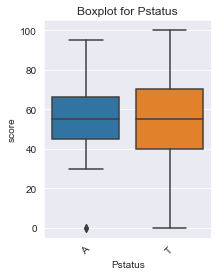

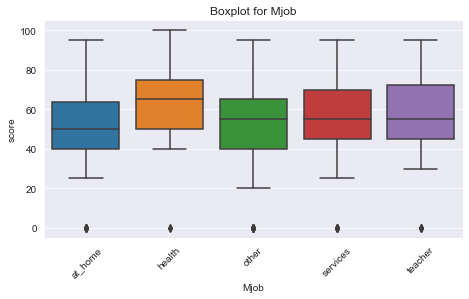

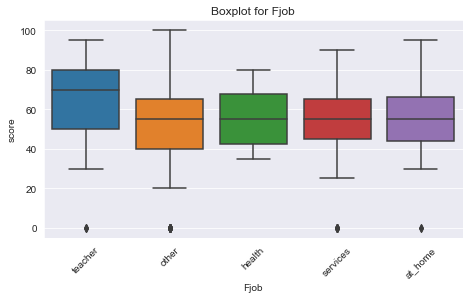

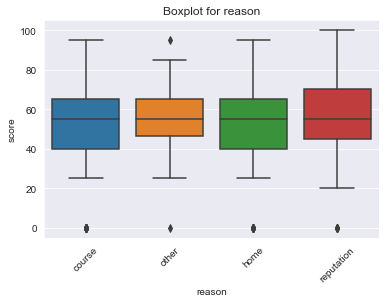

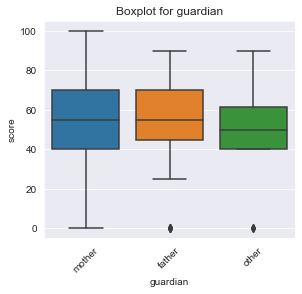

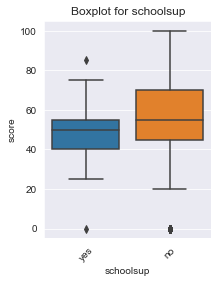

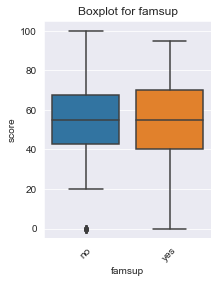

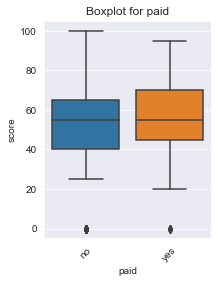

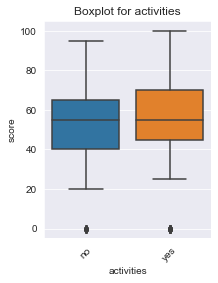

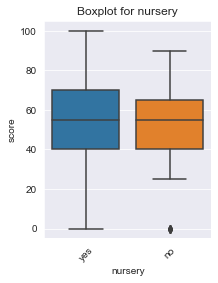

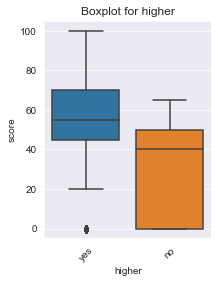

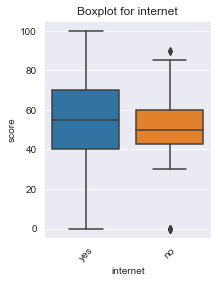

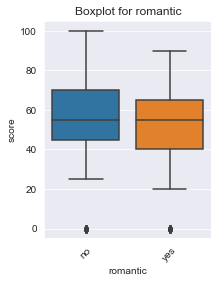

In [103]:
for col in qualitative_cols:
    show_boxplot(stud_df, col, 'score')

# Conclusions
# From the generated plots we can see that there are several qualitative variables that have similar
# boxplots for our dependent variable score. So we should check their influence on score statistically.
# These variables are:
# ['sex', 'famsize', 'Pstatus', 'reason', 'famsup', 'paid', 'activity', 'nursury', 'romantic']
# Also maybe we should consider (in some real case) merging some of the similar categories in Mjob and Fjob in one category
# e.g. [other, health, services and at_home] for Fjob could be merged in one category (with additional stat analysis).
# One more observation: if someone's father is a !teacher! - this someone shows much better results in math 8^)

In [104]:
# Considering the number of unique values in qualitative variables we will use Student's T-test for variables with only 2
# categories ['sex', 'famsize', 'Pstatus', 'famsup', 'paid', 'activities', 'nursery', 'romantic']
# and ANOVA (ANalysis Of VAriance) for feature 'reason' which consists of 4 categories with similar boxplots

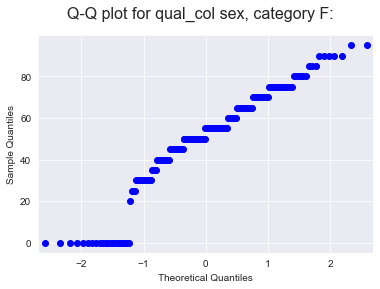

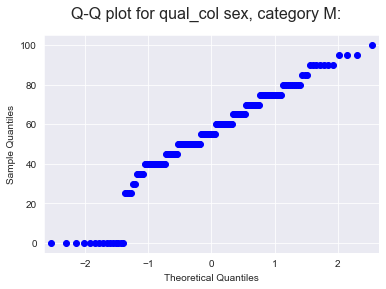

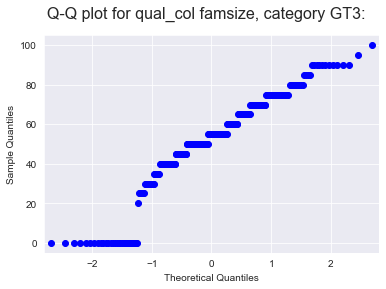

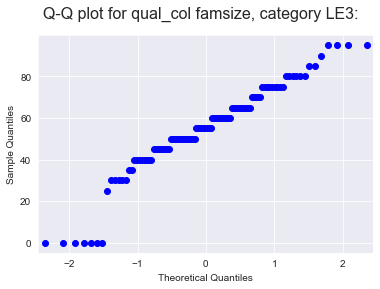

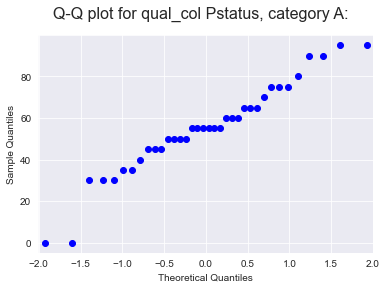

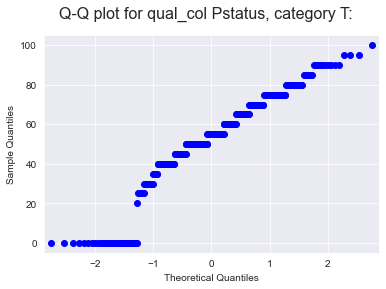

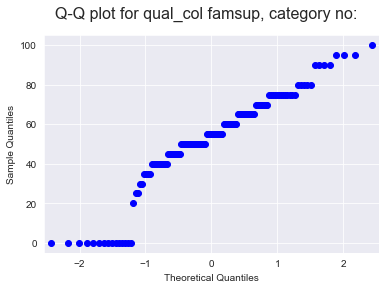

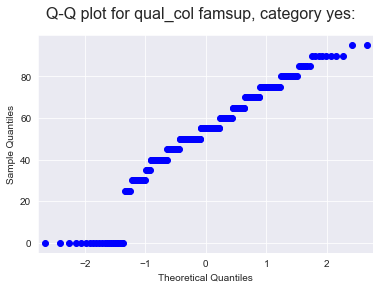

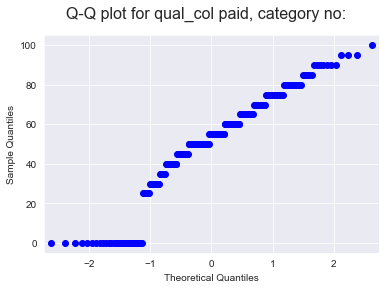

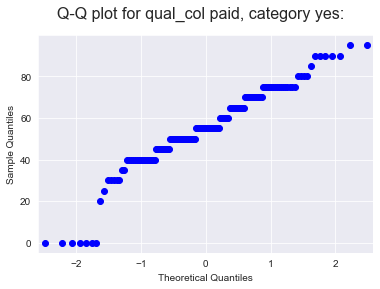

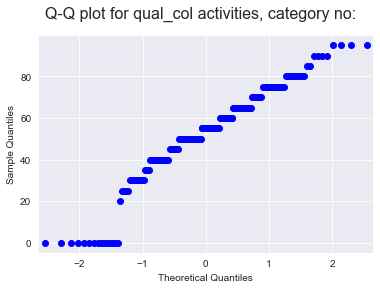

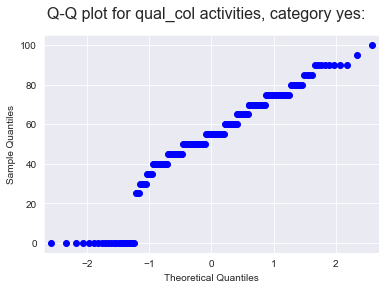

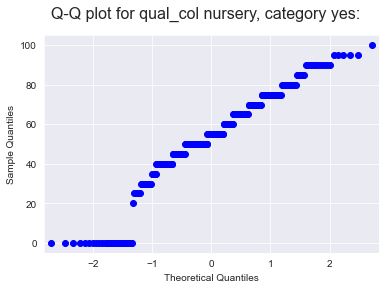

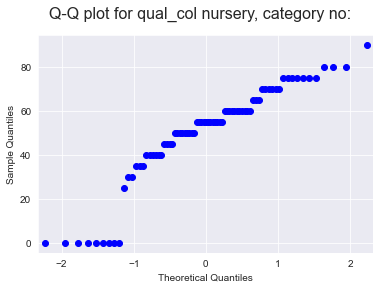

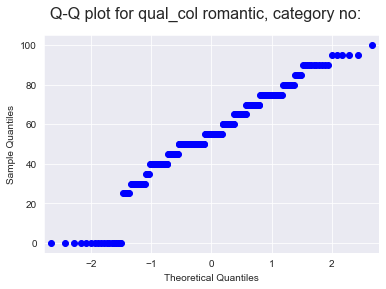

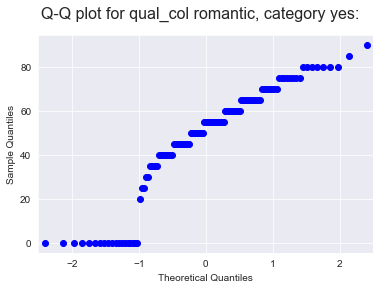

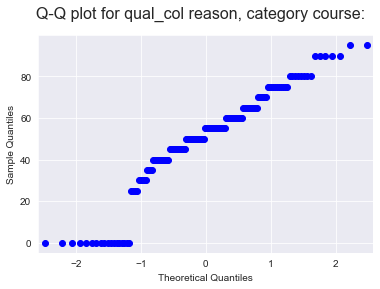

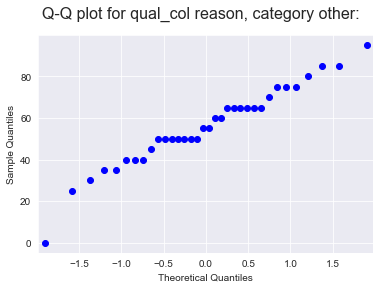

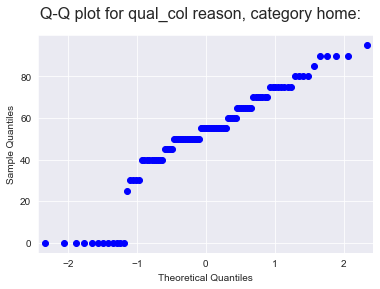

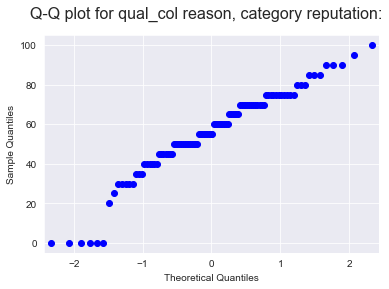

In [105]:
# In general before this we should also check if our variables have Normal distribution via such tests like
# Shapiro-Wilk Test, D’Agostino’s K^2 Test, Anderson-Darling Test and so on. But for this study case
# let's just check our data for "normality" via visual Q-Q plot

bin_qual_cols = ['sex', 'famsize', 'Pstatus', 'famsup', 'paid', 'activities', 'nursery', 'romantic']
mult_qual_cols = ['reason']
qual_cols_to_test = bin_qual_cols + mult_qual_cols

for qual_col in qual_cols_to_test:
    categories = stud_df[qual_col].unique()
    for category in categories:
        fig, ax = plt.subplots(1,1)
        category_sample = stud_df.loc[stud_df[qual_col] == category, 'score']
        sm.qqplot(category_sample.to_numpy(), ax=ax)
        fig.suptitle(f'Q-Q plot for qual_col {qual_col}, category {category}:', fontsize=16)
        plt.show()

# Conclusion for Q-Q plots
# Apart from the values of the initial quantiles we can say that we get rather "linish" plots, so
# make assumption that our data is normally distributed

In [106]:
# Statistical test for binary qualitative variables
# We choose p value threshold = 0.15 (not 0.05) because we don't want to loose to much data for further processing,
# so with 1-0.15 = 85% confidence column categories have different mean (distribution?) and probably we NEED this data
# (tricky moment, need to be discussed with mentor)
non_informative_ttest_cols = []
for qual_col in bin_qual_cols:
    if not check_ttest_diff(stud_df, qual_col, 'score', 0.15):
        non_informative_ttest_cols.append(qual_col)

# Conclusion
# Statistically significant differences via T-test were found for some columns
# So from potentially non informative columns (bin_qual_cols) we will keep only them.

# Drop non informative columns
print('Non informative T-test columns are: ', non_informative_ttest_cols)
stud_df.drop(columns=non_informative_ttest_cols, inplace=True)
stud_df.info()

Statistically significant differences via T-test were found for column 'sex', p=0.05037778594548768
NO statistically significant differences via T-test were found for column 'famsize', p=0.2016927899169685
NO statistically significant differences via T-test were found for column 'Pstatus', p=0.4299091965290761
NO statistically significant differences via T-test were found for column 'famsup', p=0.9062218328904555
Statistically significant differences via T-test were found for column 'paid', p=0.05772923393089537
NO statistically significant differences via T-test were found for column 'activities', p=0.9506721570304161
NO statistically significant differences via T-test were found for column 'nursery', p=0.3341289473359653
Statistically significant differences via T-test were found for column 'romantic', p=0.007209034891279742
Non informative T-test columns are:  ['famsize', 'Pstatus', 'famsup', 'activities', 'nursery']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 t

In [107]:
# Statistical test for multicategorical qualitative variables
# We choose p value threshold = 0.2 (not 0.05) because we don't want to loose to much data for further processing,
# so with 1-0.15 = 85% confidence column categories have different mean (distribution?) and probably we NEED this data
# (tricky moment, need to be discussed with mentor)
non_informative_anova_cols = []
for qual_col in mult_qual_cols:
    if not check_anova_diff(stud_df, qual_col, 'score', 0.15):
        non_informative_anova_cols.append(qual_col)

# Conclusion
# NO statistically significant differences via ANOVA test were found for our single column 'reason', F=1.63, p=0.179
# So we can drop non informative columns (non_informative_anova_cols) from dataset

# Drop non informative columns
print('Non informative ANOVA columns are: ', non_informative_anova_cols)
stud_df.drop(columns=non_informative_anova_cols, inplace=True)
stud_df.info()

NO statistically significant differences via ANOVA test were found for column 'reason', F=1.6397038838297673, p=0.17970376261894513
Non informative ANOVA columns are:  ['reason']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    object 
 1   sex         389 non-null    object 
 2   age         389 non-null    int64  
 3   address     389 non-null    object 
 4   Medu        389 non-null    float64
 5   Fedu        389 non-null    float64
 6   Mjob        389 non-null    object 
 7   Fjob        389 non-null    object 
 8   guardian    389 non-null    object 
 9   traveltime  389 non-null    float64
 10  studytime   389 non-null    float64
 11  failures    389 non-null    float64
 12  schoolsup   389 non-null    object 
 13  paid        389 non-null    object 
 14  higher      389 non-null    object 
 15  internet    38

# Final conclusions

1. Our data have relatively small amount of missed values.
Max percentage of missed values among columns - 11.39% (Pstatus column)
2. Outliers were found only in 3 columns (for 2 of them there was only one outlier and for column 'absences'
 there were many of them), suggesting that the data are reasonably clean.
3. Additional column 'studytime, granular' was not informative due to perfect correlation with 'studytime'
4. Some qualitative columns were excluded due to relatively low statistical significance
of the 'score' values differences between their categories (but it's a matter of chosen p-value,
we chose it conservatively)
5. So the most important features for stud_math data finally are the following 21 columns:
['school','sex','age','address','Medu','Fedu','Mjob','Fjob','guardian','traveltime','studytime',
'failures','schoolsup','paid','higher','internet','romantic', 'famrel','freetime','goout','health',
'absences','score']